In [1]:
import pandas as pd
import numpy as np
data = pd.read_csv('../input/mimic3c/mimic3c.csv')
print("With id", data.shape)

With id (58976, 28)


In [2]:
print(data.shape)
print(data.head())

(58976, 28)
   hadm_id gender  age  LOSdays admit_type             admit_location  \
0   100001      F   35     6.17  EMERGENCY  CLINIC REFERRAL/PREMATURE   
1   100003      M   59     4.04  EMERGENCY       EMERGENCY ROOM ADMIT   
2   100006      F   48    12.04  EMERGENCY       EMERGENCY ROOM ADMIT   
3   100007      F   73     7.29  EMERGENCY       EMERGENCY ROOM ADMIT   
4   100009      M   60     4.88  EMERGENCY  TRANSFER FROM HOSP/EXTRAM   

            AdmitDiagnosis insurance           religion marital_status  ...  \
0    DIABETIC KETOACIDOSIS   Private  PROTESTANT QUAKER       DIVORCED  ...   
1           UPPER GI BLEED   Private      NOT SPECIFIED         SINGLE  ...   
2               COPD FLARE   Private      NOT SPECIFIED         SINGLE  ...   
3        BOWEL OBSTRUCTION   Private             JEWISH        MARRIED  ...   
4  CORONARY ARTERY DISEASE   Private           CATHOLIC        MARRIED  ...   

  NumMicroLabs  NumNotes  NumOutput  NumRx NumProcEvents  NumTransfers  \


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
data = pd.read_csv('../input/mimic3c/mimic3c.csv')

# Initial exploration
print("Dataset Shape:", data.shape)
print("\n" + "="*50)
print("COLUMN INFORMATION:")
print("="*50)
print(data.info())
print("\n" + "="*50)
print("FIRST 5 ROWS:")
print("="*50)
print(data.head())
print("\n" + "="*50)
print("BASIC STATISTICS:")
print("="*50)
print(data.describe())
print("\n" + "="*50)
print("MISSING VALUES:")
print("="*50)
missing_values = data.isnull().sum()
missing_percent = (missing_values / len(data)) * 100
missing_info = pd.DataFrame({
    'Missing_Count': missing_values,
    'Missing_Percentage': missing_percent
})
print(missing_info[missing_info['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False))
print("\n" + "="*50)
print("UNIQUE VALUES PER COLUMN:")
print("="*50)
for col in data.columns:
    print(f"{col}: {data[col].nunique()} unique values")
print("\n" + "="*50)
print("TARGET VARIABLE DISTRIBUTION (if identifiable):")
print("="*50)
# Check for potential target columns
potential_targets = []
for col in data.columns:
    if data[col].dtype == 'object' and data[col].nunique() <= 10:
        potential_targets.append(col)
    elif data[col].dtype in ['int64', 'float64'] and data[col].nunique() <= 10:
        potential_targets.append(col)

if potential_targets:
    print("Potential target variables:")
    for target in potential_targets:
        print(f"\n{target}:")
        print(data[target].value_counts())
else:
    print("No obvious categorical target variable found. Please specify the target column.")

Dataset Shape: (58976, 28)

COLUMN INFORMATION:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   hadm_id           58976 non-null  int64  
 1   gender            58976 non-null  object 
 2   age               58976 non-null  int64  
 3   LOSdays           58976 non-null  float64
 4   admit_type        58976 non-null  object 
 5   admit_location    58976 non-null  object 
 6   AdmitDiagnosis    58951 non-null  object 
 7   insurance         58976 non-null  object 
 8   religion          58518 non-null  object 
 9   marital_status    48848 non-null  object 
 10  ethnicity         58976 non-null  object 
 11  NumCallouts       58976 non-null  float64
 12  NumDiagnosis      58976 non-null  float64
 13  NumProcs          58976 non-null  float64
 14  AdmitProcedure    58976 non-null  object 
 15  NumCPTevents      58976 non-null  float

TARGET VARIABLE: ExpiredHospital
TARGET DISTRIBUTION:
Survived (0): 53122 (90.07%)
Expired (1): 5854 (9.93%)
Class imbalance ratio: 9.07:1


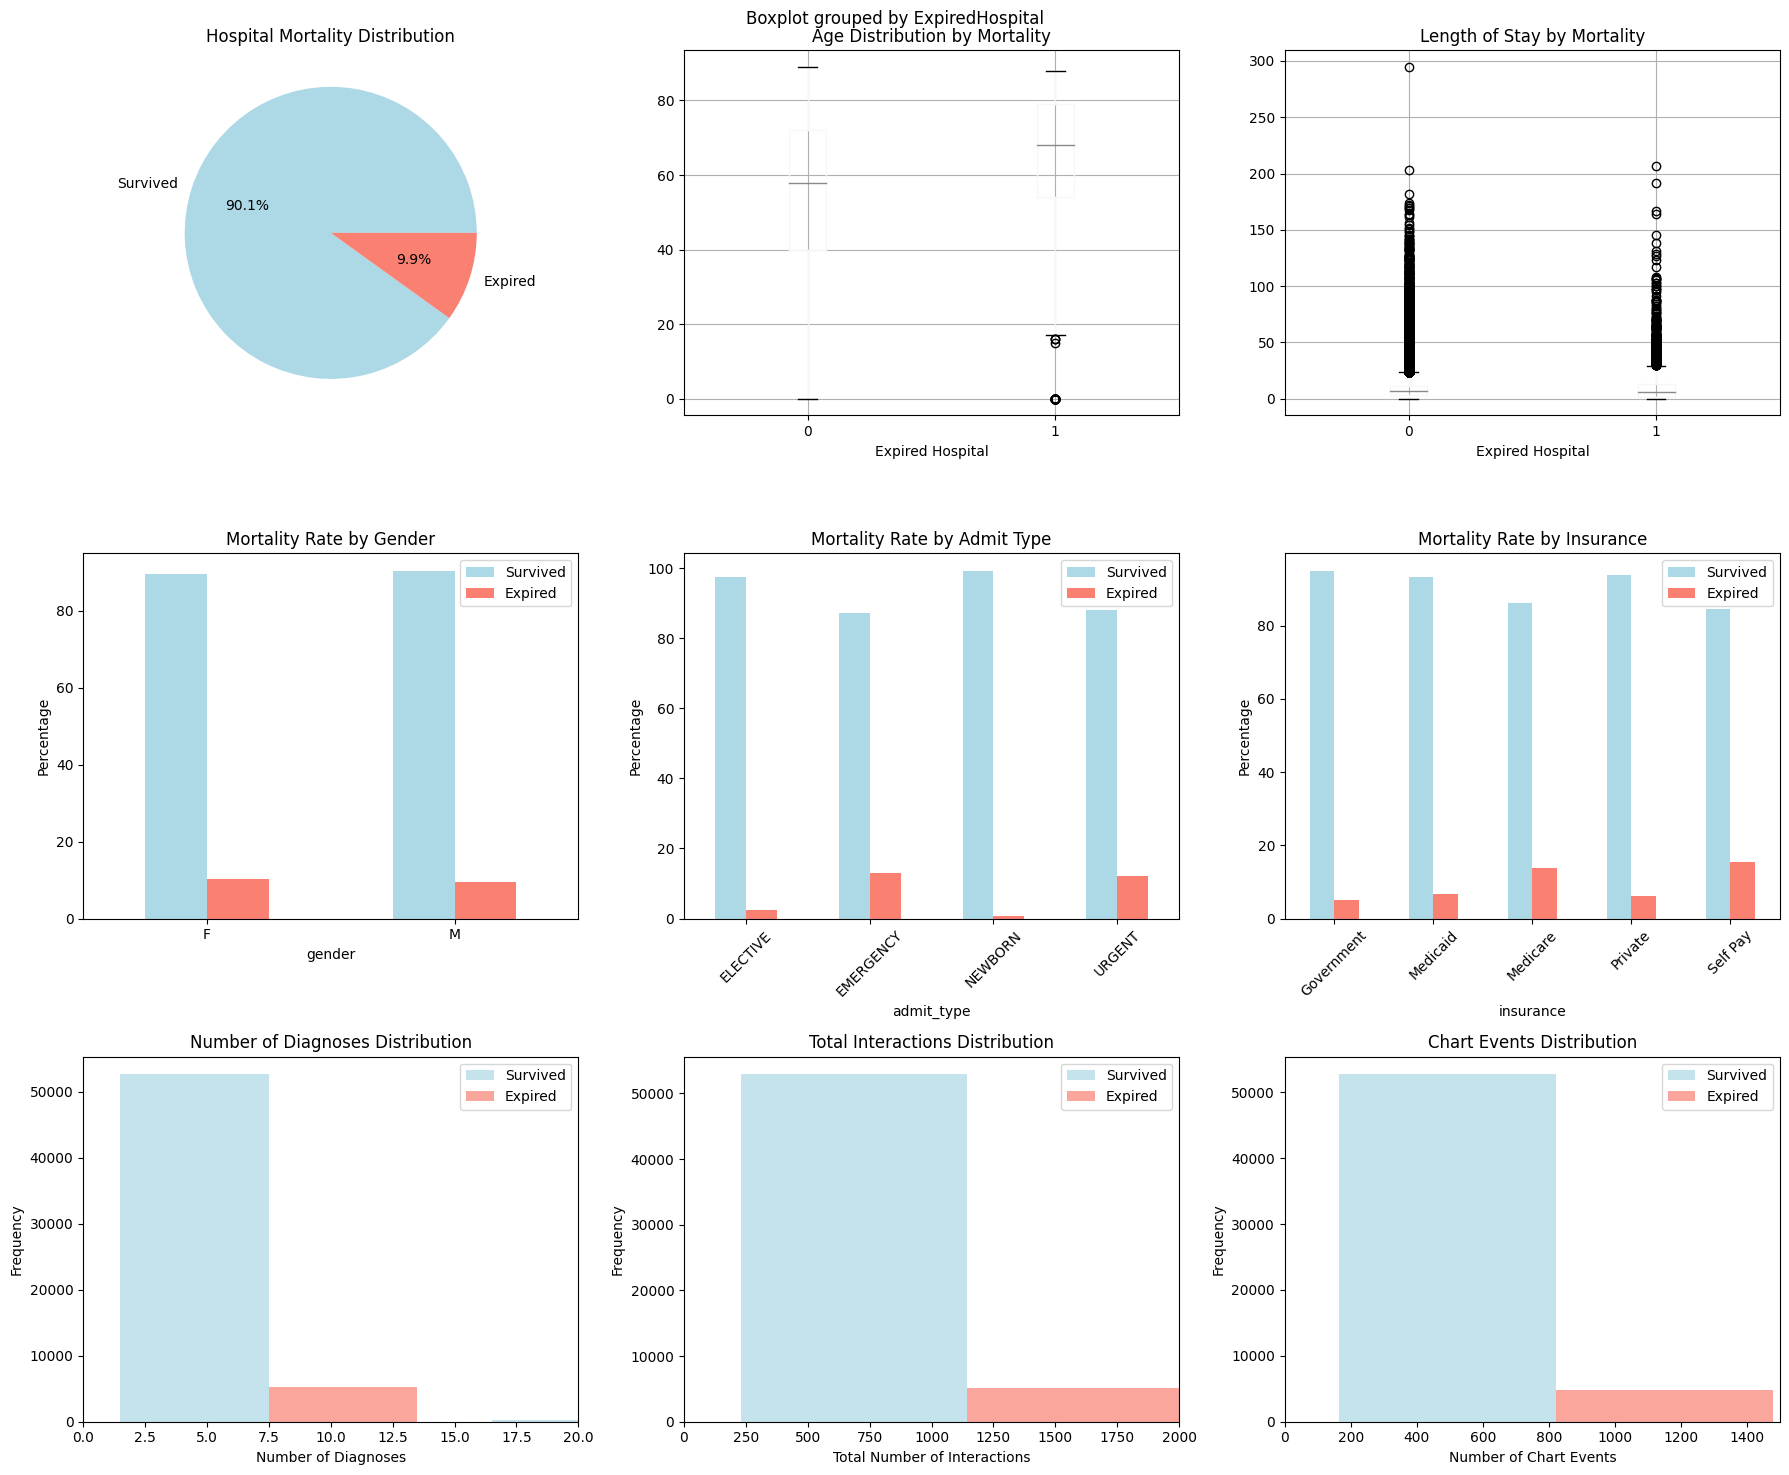


KEY INSIGHTS FROM EDA:
Average age - Survived: 51.6, Expired: 65.4
Average LOS - Survived: 10.1 days, Expired: 10.1 days

CORRELATION WITH TARGET (ExpiredHospital):
NumInput            0.368530
TotalNumInteract    0.350784
NumChartEvents      0.330790
NumLabs             0.316719
NumRx               0.298553
NumOutput           0.292912
NumCPTevents        0.222236
NumProcEvents       0.206404
NumDiagnosis        0.184477
NumMicroLabs        0.181981
Name: ExpiredHospital, dtype: float64

MISSING VALUES ANALYSIS:
Marital Status missing: 10128 (17.2%)
Religion missing: 458 (0.8%)
Admit Diagnosis missing: 25 (0.0%)

DATASET SUMMARY:
- Total samples: 58,976
- Features: 27
- Target: Hospital Mortality (Binary)
- Class distribution: 90.1% survived, 9.9% expired
- Imbalance ratio: 9.1:1 (moderate imbalance)


In [4]:
# Step 2: Comprehensive EDA
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

# Define target variable
target = 'ExpiredHospital'
print(f"TARGET VARIABLE: {target}")
print("="*60)

# Target distribution
print("TARGET DISTRIBUTION:")
target_counts = data[target].value_counts()
target_pct = data[target].value_counts(normalize=True) * 100
print(f"Survived (0): {target_counts[0]} ({target_pct[0]:.2f}%)")
print(f"Expired (1): {target_counts[1]} ({target_pct[1]:.2f}%)")
print(f"Class imbalance ratio: {target_counts[0]/target_counts[1]:.2f}:1")

# Create comprehensive EDA plots
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
fig.suptitle('MIMIC-III Dataset - Comprehensive EDA', fontsize=16, fontweight='bold')

# 1. Target distribution
axes[0,0].pie(target_counts.values, labels=['Survived', 'Expired'], autopct='%1.1f%%',
              colors=['lightblue', 'salmon'])
axes[0,0].set_title('Hospital Mortality Distribution')

# 2. Age distribution by target
data.boxplot(column='age', by=target, ax=axes[0,1])
axes[0,1].set_title('Age Distribution by Mortality')
axes[0,1].set_xlabel('Expired Hospital')

# 3. Length of Stay by target
data.boxplot(column='LOSdays', by=target, ax=axes[0,2])
axes[0,2].set_title('Length of Stay by Mortality')
axes[0,2].set_xlabel('Expired Hospital')

# 4. Gender distribution by target
gender_crosstab = pd.crosstab(data['gender'], data[target], normalize='index') * 100
gender_crosstab.plot(kind='bar', ax=axes[1,0], color=['lightblue', 'salmon'])
axes[1,0].set_title('Mortality Rate by Gender')
axes[1,0].set_ylabel('Percentage')
axes[1,0].legend(['Survived', 'Expired'])
axes[1,0].tick_params(axis='x', rotation=0)

# 5. Admit type distribution by target
admit_crosstab = pd.crosstab(data['admit_type'], data[target], normalize='index') * 100
admit_crosstab.plot(kind='bar', ax=axes[1,1], color=['lightblue', 'salmon'])
axes[1,1].set_title('Mortality Rate by Admit Type')
axes[1,1].set_ylabel('Percentage')
axes[1,1].legend(['Survived', 'Expired'])
axes[1,1].tick_params(axis='x', rotation=45)

# 6. Insurance type by target
insurance_crosstab = pd.crosstab(data['insurance'], data[target], normalize='index') * 100
insurance_crosstab.plot(kind='bar', ax=axes[1,2], color=['lightblue', 'salmon'])
axes[1,2].set_title('Mortality Rate by Insurance')
axes[1,2].set_ylabel('Percentage')
axes[1,2].legend(['Survived', 'Expired'])
axes[1,2].tick_params(axis='x', rotation=45)

# 7. Number of diagnoses distribution
axes[2,0].hist([data[data[target]==0]['NumDiagnosis'], data[data[target]==1]['NumDiagnosis']],
               bins=30, alpha=0.7, label=['Survived', 'Expired'], color=['lightblue', 'salmon'])
axes[2,0].set_title('Number of Diagnoses Distribution')
axes[2,0].set_xlabel('Number of Diagnoses')
axes[2,0].set_ylabel('Frequency')
axes[2,0].legend()
axes[2,0].set_xlim(0, 20)

# 8. Total interactions distribution
axes[2,1].hist([data[data[target]==0]['TotalNumInteract'], data[data[target]==1]['TotalNumInteract']],
               bins=30, alpha=0.7, label=['Survived', 'Expired'], color=['lightblue', 'salmon'])
axes[2,1].set_title('Total Interactions Distribution')
axes[2,1].set_xlabel('Total Number of Interactions')
axes[2,1].set_ylabel('Frequency')
axes[2,1].legend()
axes[2,1].set_xlim(0, 2000)

# 9. Chart events distribution
axes[2,2].hist([data[data[target]==0]['NumChartEvents'], data[data[target]==1]['NumChartEvents']],
               bins=30, alpha=0.7, label=['Survived', 'Expired'], color=['lightblue', 'salmon'])
axes[2,2].set_title('Chart Events Distribution')
axes[2,2].set_xlabel('Number of Chart Events')
axes[2,2].set_ylabel('Frequency')
axes[2,2].legend()
axes[2,2].set_xlim(0, 1500)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("KEY INSIGHTS FROM EDA:")
print("="*60)

# Age analysis
age_survived = data[data[target]==0]['age'].mean()
age_expired = data[data[target]==1]['age'].mean()
print(f"Average age - Survived: {age_survived:.1f}, Expired: {age_expired:.1f}")

# LOS analysis
los_survived = data[data[target]==0]['LOSdays'].mean()
los_expired = data[data[target]==1]['LOSdays'].mean()
print(f"Average LOS - Survived: {los_survived:.1f} days, Expired: {los_expired:.1f} days")

# Numerical features correlation with target
print("\nCORRELATION WITH TARGET (ExpiredHospital):")
numerical_cols = data.select_dtypes(include=[np.number]).columns.tolist()
numerical_cols.remove(target)
numerical_cols.remove('hadm_id')  # Remove ID column

correlations = data[numerical_cols + [target]].corr()[target].sort_values(key=abs, ascending=False)[1:]
print(correlations.head(10))

# Missing values impact
print(f"\nMISSING VALUES ANALYSIS:")
print(f"Marital Status missing: {data['marital_status'].isnull().sum()} ({data['marital_status'].isnull().sum()/len(data)*100:.1f}%)")
print(f"Religion missing: {data['religion'].isnull().sum()} ({data['religion'].isnull().sum()/len(data)*100:.1f}%)")
print(f"Admit Diagnosis missing: {data['AdmitDiagnosis'].isnull().sum()} ({data['AdmitDiagnosis'].isnull().sum()/len(data)*100:.1f}%)")

# High-level summary
print(f"\nDATASET SUMMARY:")
print(f"- Total samples: {len(data):,}")
print(f"- Features: {len(data.columns)-1}")
print(f"- Target: Hospital Mortality (Binary)")
print(f"- Class distribution: {target_pct[0]:.1f}% survived, {target_pct[1]:.1f}% expired")
print(f"- Imbalance ratio: {target_counts[0]/target_counts[1]:.1f}:1 (moderate imbalance)")

# **Default Models**

MIMIC-III COMPLETE CLASSIFICATION ANALYSIS PIPELINE
STEP 1: DATA LOADING AND EXPLORATION
----------------------------------------
Dataset loaded successfully!
Shape: (58976, 28)
Columns: ['hadm_id', 'gender', 'age', 'LOSdays', 'admit_type', 'admit_location', 'AdmitDiagnosis', 'insurance', 'religion', 'marital_status', 'ethnicity', 'NumCallouts', 'NumDiagnosis', 'NumProcs', 'AdmitProcedure', 'NumCPTevents', 'NumInput', 'NumLabs', 'NumMicroLabs', 'NumNotes', 'NumOutput', 'NumRx', 'NumProcEvents', 'NumTransfers', 'NumChartEvents', 'ExpiredHospital', 'TotalNumInteract', 'LOSgroupNum']

First 5 rows:
   hadm_id gender  age  LOSdays admit_type             admit_location  \
0   100001      F   35     6.17  EMERGENCY  CLINIC REFERRAL/PREMATURE   
1   100003      M   59     4.04  EMERGENCY       EMERGENCY ROOM ADMIT   
2   100006      F   48    12.04  EMERGENCY       EMERGENCY ROOM ADMIT   
3   100007      F   73     7.29  EMERGENCY       EMERGENCY ROOM ADMIT   
4   100009      M   60     4.88 

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

📊 PERFORMANCE METRICS:
   ✅ Accuracy:     0.9167
   ✅ Precision:    0.6536
   ✅ Recall:       0.3416
   ✅ F1-Score:     0.4487
   ✅ AUC-ROC:      0.7015
   ✅ CV AUC:       0.6898 (+/- 0.0304)

🔹 TRAINING: Random Forest
------------------------------------------------------------
📊 PERFORMANCE METRICS:
   ✅ Accuracy:     0.9413
   ✅ Precision:    0.8504
   ✅ Recall:       0.4953
   ✅ F1-Score:     0.6260
   ✅ AUC-ROC:      0.9255
   ✅ CV AUC:       0.9203 (+/- 0.0079)

🔹 TRAINING: Gradient Boosting
------------------------------------------------------------
📊 PERFORMANCE METRICS:
   ✅ Accuracy:     0.9390
   ✅ Precision:    0.8238
   ✅ Recall:       0.4910
   ✅ F1-Score:     0.6153
   ✅ AUC-ROC:      0.9216
   ✅ CV AUC:       0.9191 (+/- 0.0067)

🔹 TRAINING: Neural Network (MLP)
------------------------------------------------------------
📊 PERFORMANCE METRICS:
   ✅ Accuracy:     0.9374
   ✅ Precision:    0.8927
   ✅ Recall:       0.4193
   ✅ F1-Score:     0.5706
   ✅ AUC-ROC:      0.9

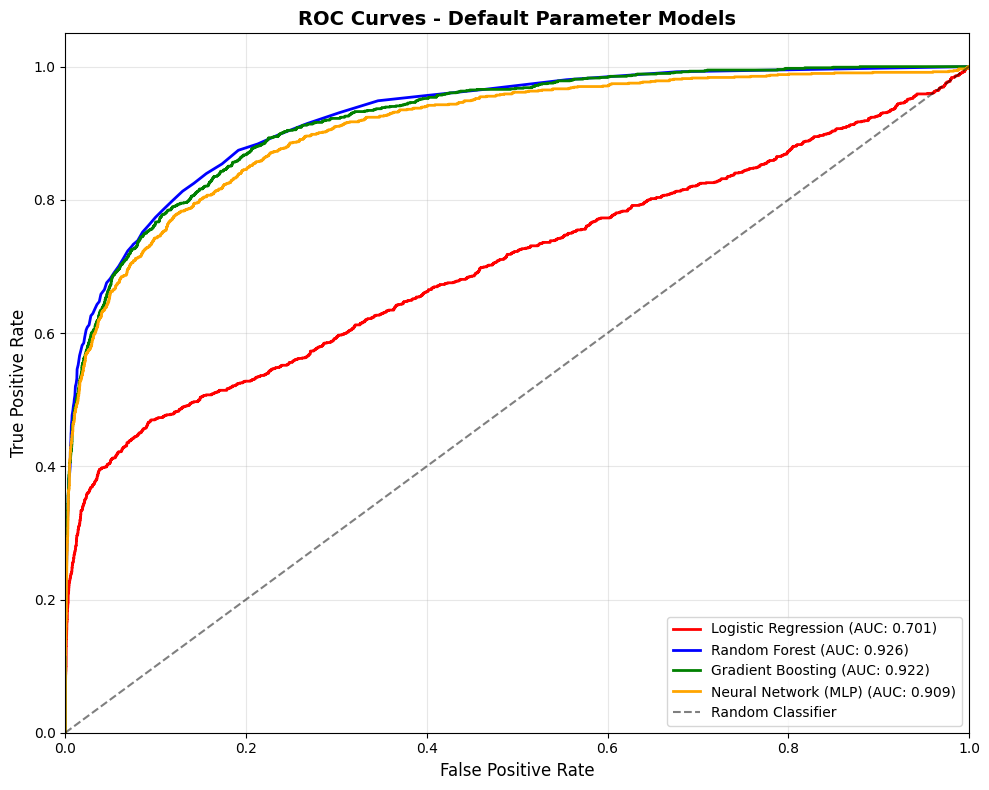


MODEL COMPARISON - DEFAULT PARAMETERS
                      Accuracy Precision    Recall  F1_Score       AUC CV_AUC_Mean
Logistic Regression   0.916667  0.653595  0.341588  0.448682  0.701466    0.689783
Random Forest         0.941251   0.85044  0.495303  0.626012  0.925503    0.920339
Gradient Boosting     0.939047  0.823782  0.491033  0.615302  0.921561    0.919084
Neural Network (MLP)  0.937352  0.892727    0.4193  0.570598  0.908925    0.835683

🏆 BEST PERFORMERS BY METRIC:
   🥇 Best Accuracy:  Random Forest (0.9413)
   🥇 Best Precision: Neural Network (MLP) (0.8927)
   🥇 Best Recall:    Random Forest (0.4953)
   🥇 Best F1-Score:  Random Forest (0.6260)
   🥇 Best AUC:       Random Forest (0.9255)

🎯 OVERALL BEST MODEL: Random Forest
   📈 AUC Score: 0.9255

DETAILED ANALYSIS - Random Forest
📋 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

     Class 0     0.9468    0.9904    0.9681     10625
     Class 1     0.8504    0.4953    0.6260      1171

    a

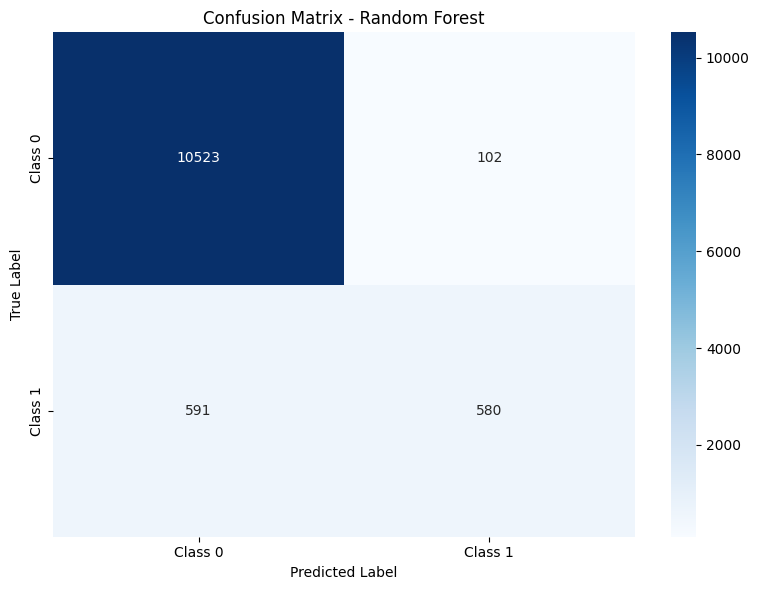


FINAL SUMMARY - DEFAULT PARAMETER MODELS
               Model Accuracy Precision Recall F1-Score AUC-ROC CV AUC
 Logistic Regression   0.9167    0.6536 0.3416   0.4487  0.7015 0.6898
       Random Forest   0.9413    0.8504 0.4953   0.6260  0.9255 0.9203
   Gradient Boosting   0.9390    0.8238 0.4910   0.6153  0.9216 0.9191
Neural Network (MLP)   0.9374    0.8927 0.4193   0.5706  0.9089 0.8357

📝 MODEL PARAMETERS USED:

Logistic Regression:
   Parameters: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}

Random Forest:
   Parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples

In [5]:
# Complete MIMIC-III Classification Analysis Pipeline
# This script includes data loading, preprocessing, and the classification models

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                           roc_curve, precision_recall_curve, average_precision_score,
                           f1_score, precision_score, recall_score, accuracy_score)
import warnings
warnings.filterwarnings('ignore')

print("MIMIC-III COMPLETE CLASSIFICATION ANALYSIS PIPELINE")
print("="*80)

# STEP 1: DATA LOADING AND EXPLORATION
print("STEP 1: DATA LOADING AND EXPLORATION")
print("-" * 40)

# Load the dataset - change this path to match your data location
# Common paths: 'mimic3c.csv', 'data/mimic3c.csv', '../input/mimic3c/mimic3c.csv'
data = pd.read_csv('../input/mimic3c/mimic3c.csv')  # Update this path as needed
# Alternative: data = pd.read_csv('mimic3c.csv')  # If file is in current directory
print(f"Dataset loaded successfully!")
print(f"Shape: {data.shape}")
print(f"Columns: {list(data.columns)}")

# Display first few rows
print("\nFirst 5 rows:")
print(data.head())

# Basic information about the dataset
print(f"\nDataset Info:")
print(data.info())

# Check for missing values
print(f"\nMissing Values:")
missing_info = data.isnull().sum()
missing_percent = (missing_info / len(data)) * 100
missing_df = pd.DataFrame({
    'Missing_Count': missing_info,
    'Missing_Percentage': missing_percent
})
print(missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False))

# STEP 2: FEATURE SELECTION AND TARGET PREPARATION
print(f"\n" + "="*80)
print("STEP 2: FEATURE SELECTION AND TARGET PREPARATION")
print("-" * 40)

# Select features for modeling (as specified)
feature_columns = [
    # Demographics
    'age', 'gender_encoded', 'ethnicity_encoded',
    # Admission details
    'admit_type_encoded', 'admit_location_encoded', 'insurance_encoded',
    'religion_encoded', 'marital_status_encoded',
    # Clinical features
    'LOSdays', 'NumDiagnosis', 'NumProcs', 'NumCallouts',
    'NumCPTevents', 'NumInput', 'NumLabs', 'NumMicroLabs',
    'NumNotes', 'NumOutput', 'NumRx', 'NumProcEvents',
    'NumTransfers', 'NumChartEvents', 'TotalNumInteract',
    # Encoded diagnosis and procedure
    'AdmitDiagnosis_encoded', 'AdmitProcedure_encoded',
    # Engineered features
    'age_group_encoded', 'los_category_encoded',
    'lab_intensity', 'med_intensity', 'procedure_intensity', 'monitoring_intensity',
    'clinical_burden', 'interaction_density',
    'high_age', 'high_los', 'high_diagnoses', 'emergency_admit', 'icu_indicator'
]

# Target variable
target_column = 'ExpiredHospital'

print(f"✅ Target variable: {target_column}")
print(f"📊 Total features selected: {len(feature_columns)}")

# Check if all required columns exist in the dataset
missing_features = [col for col in feature_columns if col not in data.columns]
missing_target = target_column not in data.columns

if missing_features:
    print(f"⚠️  Missing feature columns: {missing_features}")
    print("Available columns in dataset:")
    print(list(data.columns))
    print("\nFiltering to only available features...")
    feature_columns = [col for col in feature_columns if col in data.columns]
    print(f"✅ Using {len(feature_columns)} available features")

if missing_target:
    print(f"❌ Target column '{target_column}' not found in dataset!")
    print("Available columns:", list(data.columns))
    print("No")

# Create feature matrix and target vector
X = data[feature_columns].copy()
y = data[target_column].copy()

print(f"\n📊 FEATURE CATEGORIES:")
print("-" * 30)

# Categorize features for better understanding
demographics = ['age', 'gender_encoded', 'ethnicity_encoded']
admission_details = ['admit_type_encoded', 'admit_location_encoded', 'insurance_encoded', 
                    'religion_encoded', 'marital_status_encoded']
clinical_features = ['LOSdays', 'NumDiagnosis', 'NumProcs', 'NumCallouts', 'NumCPTevents', 
                    'NumInput', 'NumLabs', 'NumMicroLabs', 'NumNotes', 'NumOutput', 'NumRx', 
                    'NumProcEvents', 'NumTransfers', 'NumChartEvents', 'TotalNumInteract']
encoded_features = ['AdmitDiagnosis_encoded', 'AdmitProcedure_encoded']
engineered_features = ['age_group_encoded', 'los_category_encoded', 'lab_intensity', 
                      'med_intensity', 'procedure_intensity', 'monitoring_intensity',
                      'clinical_burden', 'interaction_density', 'high_age', 'high_los', 
                      'high_diagnoses', 'emergency_admit', 'icu_indicator']

print(f"Demographics ({len([f for f in demographics if f in feature_columns])}): {[f for f in demographics if f in feature_columns]}")
print(f"Admission Details ({len([f for f in admission_details if f in feature_columns])}): {[f for f in admission_details if f in feature_columns]}")
print(f"Clinical Features ({len([f for f in clinical_features if f in feature_columns])}): {[f for f in clinical_features if f in feature_columns]}")
print(f"Encoded Features ({len([f for f in encoded_features if f in feature_columns])}): {[f for f in encoded_features if f in feature_columns]}")
print(f"Engineered Features ({len([f for f in engineered_features if f in feature_columns])}): {[f for f in engineered_features if f in feature_columns]}")

print(f"\n📈 DATA SUMMARY:")
print(f"   Features shape: {X.shape}")
print(f"   Target shape: {y.shape}")
print(f"   Target distribution:\n{y.value_counts()}")

# Check for missing values in selected features
missing_in_features = X.isnull().sum()
if missing_in_features.sum() > 0:
    print(f"\n⚠️  Missing values in features:")
    print(missing_in_features[missing_in_features > 0])
    
    # Simple imputation for missing values
    print("Applying simple imputation...")
    X = X.fillna(X.median())
    print("✅ Missing values filled with median")

print(f"\n✅ Feature matrix and target ready for modeling!")
print(f"   Final X shape: {X.shape}")
print(f"   Final y shape: {y.shape}")
print(f"   Target classes: {sorted(y.unique())}")

# STEP 4: BASIC CLASSIFICATION MODELS WITH DEFAULT PARAMETERS
print(f"\n" + "="*80)
print("STEP 4: BASIC CLASSIFICATION MODELS WITH DEFAULT PARAMETERS")
print("="*80)

# 1. TRAIN-TEST SPLIT (STRATIFIED)
print("1. SPLITTING DATA...")
print("-" * 40)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Training class distribution: {y_train.value_counts().to_dict()}")
print(f"Test class distribution: {y_test.value_counts().to_dict()}")


print("-" * 40)


X_train_scaled =(X_train)
X_test_scaled = (X_test)



# 3. DEFINE MODELS WITH DEFAULT PARAMETERS
print("\n3. DEFINING MODELS WITH DEFAULT PARAMETERS...")
print("-" * 40)

# All models with completely default parameters
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Neural Network (MLP)': MLPClassifier(random_state=42, max_iter=200)
}

print("Models defined with default parameters only (Neural Network max_iter=200 to ensure convergence)")

# 4. TRAIN MODELS AND COLLECT RESULTS
model_results = {}
trained_models = {}

# Create figure for ROC curves
plt.figure(figsize=(10, 8))
colors = ['red', 'blue', 'green', 'orange', 'purple']

print("\n" + "="*80)
print("MODEL TRAINING AND EVALUATION RESULTS")
print("="*80)

for i, (name, model) in enumerate(models.items()):
    print(f"\n🔹 TRAINING: {name}")
    print("-" * 60)
    
    # Train model with default parameters on scaled data
    model.fit(X_train_scaled, y_train)
    
    # Cross-validation on training set
    cv_scores = cross_val_score(model, X_train_scaled, y_train, 
                               cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                               scoring='roc_auc', n_jobs=-1)
    
    # Predictions on test set
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # Calculate all metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    
    # Store results
    model_results[name] = {
        'CV_AUC_Mean': cv_scores.mean(),
        'CV_AUC_Std': cv_scores.std(),
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1_Score': f1,
        'AUC': auc_score,
        'Predictions': y_pred,
        'Probabilities': y_pred_proba
    }
    
    trained_models[name] = model
    
    # Print detailed metrics for this model
    print(f"📊 PERFORMANCE METRICS:")
    print(f"   ✅ Accuracy:     {accuracy:.4f}")
    print(f"   ✅ Precision:    {precision:.4f}")
    print(f"   ✅ Recall:       {recall:.4f}")
    print(f"   ✅ F1-Score:     {f1:.4f}")
    print(f"   ✅ AUC-ROC:      {auc_score:.4f}")
    print(f"   ✅ CV AUC:       {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")
    
    # Calculate and plot ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, linewidth=2, color=colors[i], 
             label=f'{name} (AUC: {auc_score:.3f})')

# Finalize ROC plot
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Default Parameter Models', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 5. MODEL COMPARISON TABLE
print("\n" + "="*80)
print("MODEL COMPARISON - DEFAULT PARAMETERS")
print("="*80)

# Create comparison DataFrame
comparison_df = pd.DataFrame(model_results).T
comparison_df = comparison_df[['Accuracy', 'Precision', 'Recall', 'F1_Score', 'AUC', 'CV_AUC_Mean']].round(4)

print(comparison_df.to_string())

# Find best model for each metric
print(f"\n🏆 BEST PERFORMERS BY METRIC:")
print(f"   🥇 Best Accuracy:  {comparison_df['Accuracy'].idxmax()} ({comparison_df['Accuracy'].max():.4f})")
print(f"   🥇 Best Precision: {comparison_df['Precision'].idxmax()} ({comparison_df['Precision'].max():.4f})")
print(f"   🥇 Best Recall:    {comparison_df['Recall'].idxmax()} ({comparison_df['Recall'].max():.4f})")
print(f"   🥇 Best F1-Score:  {comparison_df['F1_Score'].idxmax()} ({comparison_df['F1_Score'].max():.4f})")
print(f"   🥇 Best AUC:       {comparison_df['AUC'].idxmax()} ({comparison_df['AUC'].max():.4f})")

# Overall best model (based on AUC)
best_model_name = comparison_df['AUC'].idxmax()
print(f"\n🎯 OVERALL BEST MODEL: {best_model_name}")
print(f"   📈 AUC Score: {comparison_df.loc[best_model_name, 'AUC']:.4f}")

# 6. DETAILED EVALUATION OF BEST MODEL
print(f"\n" + "="*80)
print(f"DETAILED ANALYSIS - {best_model_name}")
print("="*80)

best_predictions = model_results[best_model_name]['Predictions']
best_probabilities = model_results[best_model_name]['Probabilities']

# Classification Report
print("📋 CLASSIFICATION REPORT:")
target_names = ['Class 0', 'Class 1']  # Adjust based on your target
print(classification_report(y_test, best_predictions, target_names=target_names, digits=4))

# Confusion Matrix
print("\n📊 CONFUSION MATRIX:")
cm = confusion_matrix(y_test, best_predictions)
print(cm)

# Calculate additional metrics
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
npv = tn / (tn + fn) if (tn + fn) > 0 else 0

print(f"\n📈 ADDITIONAL METRICS:")
print(f"   ✅ Sensitivity (True Positive Rate): {sensitivity:.4f}")
print(f"   ✅ Specificity (True Negative Rate): {specificity:.4f}")
print(f"   ✅ Positive Predictive Value (PPV):  {ppv:.4f}")
print(f"   ✅ Negative Predictive Value (NPV):  {npv:.4f}")

# 7. VISUALIZATION - CONFUSION MATRIX HEATMAP
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# 8. FINAL SUMMARY
print(f"\n" + "="*80)
print("FINAL SUMMARY - DEFAULT PARAMETER MODELS")
print("="*80)

# Create a summary table
summary_data = []
for model_name, results in model_results.items():
    summary_data.append({
        'Model': model_name,
        'Accuracy': f"{results['Accuracy']:.4f}",
        'Precision': f"{results['Precision']:.4f}",
        'Recall': f"{results['Recall']:.4f}",
        'F1-Score': f"{results['F1_Score']:.4f}",
        'AUC-ROC': f"{results['AUC']:.4f}",
        'CV AUC': f"{results['CV_AUC_Mean']:.4f}"
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

print(f"\n📝 MODEL PARAMETERS USED:")
for name, model in trained_models.items():
    print(f"\n{name}:")
    print(f"   Parameters: {model.get_params()}")

print(f"\n🎯 SUMMARY:")
print(f"   📊 Total models trained: {len(model_results)}")
print(f"   🏆 Best model: {best_model_name}")
print(f"   📈 Best AUC: {comparison_df['AUC'].max():.4f}")
print(f"   ⚙️  All models used default parameters")
print(f"   🚫 No class balancing or optimization applied")
print(f"   📋 All standard metrics calculated and displayed")
print(f"   🎲 Target variable: {target_column}")
print(f"   📊 Dataset: {data.shape[0]} samples, {X.shape[1]} features")

print(f"\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)

# **Improvement**

In [6]:
# Step 3: Data Preprocessing and Feature Engineering
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np

print("STEP 3: DATA PREPROCESSING & FEATURE ENGINEERING")
print("="*60)

# Create a copy for preprocessing
df = data.copy()
print(f"Original dataset shape: {df.shape}")

# 1. HANDLE MISSING VALUES
print("\n1. HANDLING MISSING VALUES...")
print("-" * 40)

# Fill missing marital_status with mode
df['marital_status'].fillna(df['marital_status'].mode()[0], inplace=True)

# Fill missing religion with 'UNKNOWN'
df['religion'].fillna('UNKNOWN', inplace=True)

# Fill missing AdmitDiagnosis with mode
df['AdmitDiagnosis'].fillna(df['AdmitDiagnosis'].mode()[0], inplace=True)

print("Missing values after imputation:")
print(df.isnull().sum().sum())

# 2. FEATURE ENGINEERING
print("\n2. FEATURE ENGINEERING...")
print("-" * 40)

# Age groups (clinical relevance)
df['age_group'] = pd.cut(df['age'],
                        bins=[0, 18, 35, 50, 65, 80, 100],
                        labels=['pediatric', 'young_adult', 'adult', 'middle_aged', 'elderly', 'very_elderly'])

# LOS categories
df['los_category'] = pd.cut(df['LOSdays'],
                           bins=[0, 2, 7, 14, 30, 300],
                           labels=['very_short', 'short', 'medium', 'long', 'very_long'])

# Clinical activity intensity features
df['lab_intensity'] = df['NumLabs'] / (df['LOSdays'] + 1)  # +1 to avoid division by zero
df['med_intensity'] = df['NumRx'] / (df['LOSdays'] + 1)
df['procedure_intensity'] = df['NumProcs'] / (df['LOSdays'] + 1)
df['monitoring_intensity'] = df['NumChartEvents'] / (df['LOSdays'] + 1)

# Total clinical burden score
df['clinical_burden'] = (df['NumDiagnosis'] + df['NumProcs'] + df['NumCallouts'])

# Interaction density
df['interaction_density'] = df['TotalNumInteract'] / (df['LOSdays'] + 1)

# High-risk indicators
df['high_age'] = (df['age'] >= 70).astype(int)
df['high_los'] = (df['LOSdays'] >= 14).astype(int)
df['high_diagnoses'] = (df['NumDiagnosis'] >= df['NumDiagnosis'].quantile(0.75)).astype(int)
df['emergency_admit'] = (df['admit_type'] == 'EMERGENCY').astype(int)

# ICU indicators (based on high monitoring)
df['icu_indicator'] = (df['NumChartEvents'] >= df['NumChartEvents'].quantile(0.90)).astype(int)

print(f"New features created: {len(df.columns) - len(data.columns)}")
print("New feature list:")
new_features = [col for col in df.columns if col not in data.columns]
for feature in new_features:
    print(f"  - {feature}")

# 3. ENCODE CATEGORICAL VARIABLES
print("\n3. ENCODING CATEGORICAL VARIABLES...")
print("-" * 40)

# Initialize label encoders
label_encoders = {}

# Categorical columns to encode
categorical_cols = ['gender', 'admit_type', 'admit_location', 'insurance',
                   'religion', 'marital_status', 'ethnicity', 'age_group', 'los_category']

# Apply label encoding
for col in categorical_cols:
    le = LabelEncoder()
    df[col + '_encoded'] = le.fit_transform(df[col])
    label_encoders[col] = le
    print(f"  {col}: {len(le.classes_)} categories -> encoded")

# 4. HANDLE HIGH CARDINALITY FEATURES
print("\n4. HANDLING HIGH CARDINALITY FEATURES...")
print("-" * 40)

# AdmitDiagnosis and AdmitProcedure have too many unique values
# Create frequency-based encoding
diagnosis_freq = df['AdmitDiagnosis'].value_counts()
procedure_freq = df['AdmitProcedure'].value_counts()

# Keep top 50 most frequent, group others as 'OTHER'
top_diagnoses = diagnosis_freq.head(50).index
top_procedures = procedure_freq.head(50).index

df['AdmitDiagnosis_grouped'] = df['AdmitDiagnosis'].apply(
    lambda x: x if x in top_diagnoses else 'OTHER'
)
df['AdmitProcedure_grouped'] = df['AdmitProcedure'].apply(
    lambda x: x if x in top_procedures else 'OTHER'
)

# Encode the grouped versions
le_diag = LabelEncoder()
le_proc = LabelEncoder()
df['AdmitDiagnosis_encoded'] = le_diag.fit_transform(df['AdmitDiagnosis_grouped'])
df['AdmitProcedure_encoded'] = le_proc.fit_transform(df['AdmitProcedure_grouped'])

print(f"  AdmitDiagnosis: {len(diagnosis_freq)} -> {len(le_diag.classes_)} categories")
print(f"  AdmitProcedure: {len(procedure_freq)} -> {len(le_proc.classes_)} categories")

# 5. FEATURE SELECTION FOR MODELING
print("\n5. PREPARING FEATURE SET...")
print("-" * 40)

# Select features for modeling
feature_columns = [
    # Demographics
    'age', 'gender_encoded', 'ethnicity_encoded',

    # Admission details
    'admit_type_encoded', 'admit_location_encoded', 'insurance_encoded',
    'religion_encoded', 'marital_status_encoded',

    # Clinical features
    'LOSdays', 'NumDiagnosis', 'NumProcs', 'NumCallouts',
    'NumCPTevents', 'NumInput', 'NumLabs', 'NumMicroLabs',
    'NumNotes', 'NumOutput', 'NumRx', 'NumProcEvents',
    'NumTransfers', 'NumChartEvents', 'TotalNumInteract',

    # Encoded diagnosis and procedure
    'AdmitDiagnosis_encoded', 'AdmitProcedure_encoded',

    # Engineered features
    'age_group_encoded', 'los_category_encoded',
    'lab_intensity', 'med_intensity', 'procedure_intensity', 'monitoring_intensity',
    'clinical_burden', 'interaction_density',
    'high_age', 'high_los', 'high_diagnoses', 'emergency_admit', 'icu_indicator'
]

# Create feature matrix
X = df[feature_columns].copy()
y = df['ExpiredHospital'].copy()

print(f"Final feature set: {X.shape[1]} features")
print(f"Target distribution: {y.value_counts().to_dict()}")

# 6. HANDLE OUTLIERS (using IQR method for key continuous features)
print("\n6. OUTLIER HANDLING...")
print("-" * 40)

continuous_features = ['LOSdays', 'NumDiagnosis', 'NumInput', 'NumLabs', 'NumChartEvents',
                      'TotalNumInteract', 'lab_intensity', 'med_intensity', 'monitoring_intensity']

outlier_stats = {}
for feature in continuous_features:
    Q1 = X[feature].quantile(0.25)
    Q3 = X[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers_before = ((X[feature] < lower_bound) | (X[feature] > upper_bound)).sum()

    # Cap outliers instead of removing them
    X[feature] = np.clip(X[feature], lower_bound, upper_bound)

    outlier_stats[feature] = outliers_before

print("Outliers capped per feature:")
for feature, count in outlier_stats.items():
    if count > 0:
        print(f"  {feature}: {count} outliers capped")

# 7. FINAL DATASET INFO
print(f"\n7. FINAL PREPROCESSED DATASET:")
print("-" * 40)
print(f"Shape: {X.shape}")
print(f"Features: {list(X.columns)}")
print(f"Target class distribution:")
print(f"  Survived (0): {(y==0).sum()} ({(y==0).sum()/len(y)*100:.1f}%)")
print(f"  Expired (1): {(y==1).sum()} ({(y==1).sum()/len(y)*100:.1f}%)")
print(f"Missing values in X: {X.isnull().sum().sum()}")
print(f"Missing values in y: {y.isnull().sum()}")

# Check for any remaining issues
print(f"\nData quality check:")
print(f"- Infinite values: {np.isinf(X).sum().sum()}")
print(f"- NaN values: {X.isnull().sum().sum()}")
print(f"- Feature dtypes: {X.dtypes.value_counts().to_dict()}")

print("\nPreprocessing completed successfully!")
print("Ready for model training...")

STEP 3: DATA PREPROCESSING & FEATURE ENGINEERING
Original dataset shape: (58976, 28)

1. HANDLING MISSING VALUES...
----------------------------------------
Missing values after imputation:
0

2. FEATURE ENGINEERING...
----------------------------------------
New features created: 13
New feature list:
  - age_group
  - los_category
  - lab_intensity
  - med_intensity
  - procedure_intensity
  - monitoring_intensity
  - clinical_burden
  - interaction_density
  - high_age
  - high_los
  - high_diagnoses
  - emergency_admit
  - icu_indicator

3. ENCODING CATEGORICAL VARIABLES...
----------------------------------------
  gender: 2 categories -> encoded
  admit_type: 4 categories -> encoded
  admit_location: 9 categories -> encoded
  insurance: 5 categories -> encoded
  religion: 21 categories -> encoded
  marital_status: 7 categories -> encoded
  ethnicity: 41 categories -> encoded
  age_group: 7 categories -> encoded
  los_category: 6 categories -> encoded

4. HANDLING HIGH CARDINALITY 

In [7]:
##############################

STEP 4: HIGH-PERFORMANCE CLASSIFICATION MODEL
1. SPLITTING DATA...
----------------------------------------
Training set: 47180 samples
Test set: 11796 samples
Training class distribution: {0: 42497, 1: 4683}
Test class distribution: {0: 10625, 1: 1171}

2. FEATURE SCALING...
----------------------------------------
Features scaled using StandardScaler

3. HANDLING CLASS IMBALANCE...
----------------------------------------
Class weights: {0: 0.5550980069181354, 1: 5.037369207772795}
Scale pos weight: 9.075
Before oversampling: {0: 42497, 1: 4683}
After oversampling: {0: 42497, 1: 42497}

4. TRAINING MULTIPLE MODELS...
----------------------------------------

DETAILED MODEL PERFORMANCE RESULTS

🔹 TRAINING: Logistic Regression
------------------------------------------------------------
📊 PERFORMANCE METRICS:
   ✅ Accuracy:     0.8416
   ✅ Precision:    0.3595
   ✅ Recall:       0.7617
   ✅ F1-Score:     0.4885
   ✅ AUC-ROC:      0.8902
   ✅ CV AUC:       0.8920 (+/- 0.0101)

🔹 TRAININ

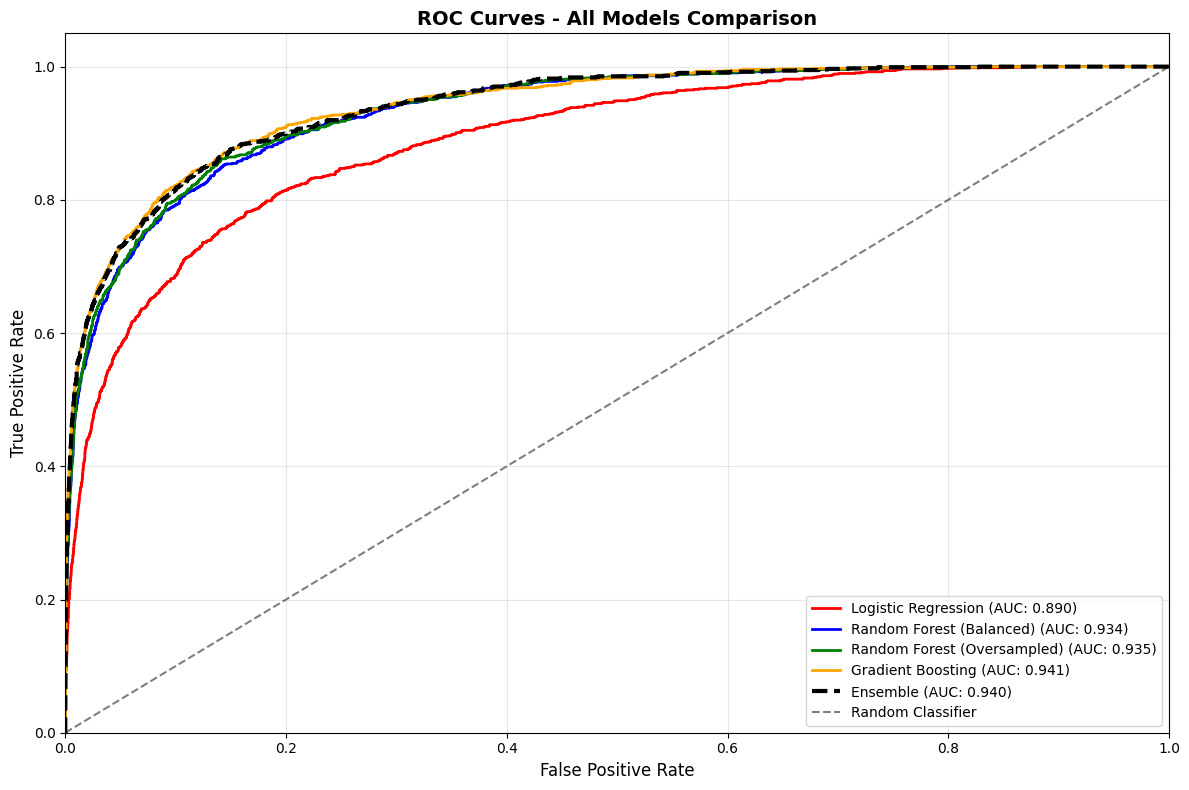


COMPREHENSIVE MODEL COMPARISON
                             Accuracy Precision    Recall  F1_Score       AUC CV_AUC_Mean
Logistic Regression          0.841641  0.359532  0.761742  0.488499  0.890191     0.89198
Random Forest (Balanced)     0.937521  0.725104  0.596926  0.654801  0.933681    0.930683
Random Forest (Oversampled)  0.933452  0.666093  0.660974  0.663523  0.935382    0.994602
Gradient Boosting            0.945236  0.818955  0.575576  0.676028  0.940603    0.937694
Ensemble (Top 3)             0.944388  0.782037  0.609735  0.685221  0.939691    0.954327

🏆 BEST PERFORMERS BY METRIC:
   🥇 Best Accuracy:  Gradient Boosting (0.9452)
   🥇 Best Precision: Gradient Boosting (0.8190)
   🥇 Best Recall:    Logistic Regression (0.7617)
   🥇 Best F1-Score:  Ensemble (Top 3) (0.6852)
   🥇 Best AUC:       Gradient Boosting (0.9406)

🎯 OVERALL BEST MODEL: Gradient Boosting
   📈 AUC Score: 0.9406

DETAILED ANALYSIS - Gradient Boosting
📋 CLASSIFICATION REPORT:
              precision    re

In [8]:
# Step 4: High-Performance Classification Model (Enhanced with Detailed Metrics)
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                           roc_curve, precision_recall_curve, average_precision_score,
                           f1_score, precision_score, recall_score, accuracy_score)
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

print("STEP 4: HIGH-PERFORMANCE CLASSIFICATION MODEL")
print("="*60)

# 1. TRAIN-TEST SPLIT (STRATIFIED)
print("1. SPLITTING DATA...")
print("-" * 40)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Training class distribution: {y_train.value_counts().to_dict()}")
print(f"Test class distribution: {y_test.value_counts().to_dict()}")

# 2. FEATURE SCALING
print("\n2. FEATURE SCALING...")
print("-" * 40)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled using StandardScaler")

# 3. CALCULATE CLASS WEIGHTS FOR IMBALANCE HANDLING
print("\n3. HANDLING CLASS IMBALANCE...")
print("-" * 40)

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
scale_pos_weight = class_weights[1] / class_weights[0]

print(f"Class weights: {class_weight_dict}")
print(f"Scale pos weight: {scale_pos_weight:.3f}")

# Manual oversampling function (alternative to SMOTE)
def manual_oversample(X, y, random_state=42):
    """Simple random oversampling to balance classes"""
    np.random.seed(random_state)
    
    # Separate majority and minority classes
    majority_class = 0
    minority_class = 1
    
    X_majority = X[y == majority_class]
    X_minority = X[y == minority_class]
    y_majority = y[y == majority_class]
    y_minority = y[y == minority_class]
    
    # Calculate how many samples to add
    n_majority = len(X_majority)
    n_minority = len(X_minority)
    n_to_add = n_majority - n_minority
    
    # Randomly sample from minority class with replacement
    indices = np.random.choice(len(X_minority), size=n_to_add, replace=True)
    X_minority_upsampled = X_minority[indices]
    y_minority_upsampled = y_minority.iloc[indices]
    
    # Combine majority and upsampled minority
    X_balanced = np.vstack([X_majority, X_minority, X_minority_upsampled])
    y_balanced = np.hstack([y_majority, y_minority, y_minority_upsampled])
    
    return X_balanced, y_balanced

# Apply manual oversampling
X_train_balanced, y_train_balanced = manual_oversample(X_train_scaled, y_train, random_state=42)

print(f"Before oversampling: {pd.Series(y_train).value_counts().to_dict()}")
print(f"After oversampling: {pd.Series(y_train_balanced).value_counts().to_dict()}")

# 4. MODEL TRAINING WITH MULTIPLE ALGORITHMS
print("\n4. TRAINING MULTIPLE MODELS...")
print("-" * 40)

# Define models with class-aware configurations
models = {
    'Logistic Regression': LogisticRegression(
        random_state=42, 
        max_iter=1000,
        class_weight='balanced',
        C=0.1
    ),
    
    'Random Forest (Balanced)': RandomForestClassifier(
        n_estimators=200,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        class_weight='balanced',
        n_jobs=-1
    ),
    
    'Random Forest (Oversampled)': RandomForestClassifier(
        n_estimators=200,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    ),
    
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=6,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42
    )
}

# Train models and collect results
model_results = {}
trained_models = {}

# Create figure for ROC curves
plt.figure(figsize=(12, 8))
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']
roc_data = {}

print("\n" + "="*80)
print("DETAILED MODEL PERFORMANCE RESULTS")
print("="*80)

for i, (name, model) in enumerate(models.items()):
    print(f"\n🔹 TRAINING: {name}")
    print("-" * 60)
    
    # Use different data based on model type
    if 'Oversampled' in name:
        X_train_use, y_train_use = X_train_balanced, y_train_balanced
    else:
        X_train_use, y_train_use = X_train_scaled, y_train
    
    # Train model
    model.fit(X_train_use, y_train_use)
    
    # Cross-validation on training set
    cv_scores = cross_val_score(model, X_train_use, y_train_use, 
                               cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                               scoring='roc_auc', n_jobs=-1)
    
    # Predictions on test set
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # Calculate all metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    avg_precision = average_precision_score(y_test, y_pred_proba)
    
    # Store results
    model_results[name] = {
        'CV_AUC_Mean': cv_scores.mean(),
        'CV_AUC_Std': cv_scores.std(),
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1_Score': f1,
        'AUC': auc_score,
        'Avg_Precision': avg_precision,
        'Predictions': y_pred,
        'Probabilities': y_pred_proba
    }
    
    trained_models[name] = model
    
    # Print detailed metrics for this model
    print(f"📊 PERFORMANCE METRICS:")
    print(f"   ✅ Accuracy:     {accuracy:.4f}")
    print(f"   ✅ Precision:    {precision:.4f}")
    print(f"   ✅ Recall:       {recall:.4f}")
    print(f"   ✅ F1-Score:     {f1:.4f}")
    print(f"   ✅ AUC-ROC:      {auc_score:.4f}")
    print(f"   ✅ CV AUC:       {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")
    
    # Calculate and store ROC curve data
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_data[name] = {'fpr': fpr, 'tpr': tpr, 'auc': auc_score}
    
    # Plot ROC curve
    plt.plot(fpr, tpr, linewidth=2, color=colors[i % len(colors)], 
             label=f'{name} (AUC: {auc_score:.3f})')

# 5. CREATE ENSEMBLE MODEL
print(f"\n🔹 TRAINING: Ensemble Model")
print("-" * 60)

# Get predictions from top 3 models
ensemble_probabilities = np.zeros(len(y_test))
top_3_models = sorted(model_results.items(), key=lambda x: x[1]['AUC'], reverse=True)[:3]

print(f"📋 Top 3 models for ensemble:")
for rank, (name, results) in enumerate(top_3_models, 1):
    print(f"   {rank}. {name} (AUC: {results['AUC']:.4f})")

weights = [0.4, 0.35, 0.25]  # Weighted ensemble
for i, (name, results) in enumerate(top_3_models):
    ensemble_probabilities += weights[i] * results['Probabilities']

ensemble_predictions = (ensemble_probabilities > 0.5).astype(int)

# Calculate ensemble metrics
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
ensemble_precision = precision_score(y_test, ensemble_predictions)
ensemble_recall = recall_score(y_test, ensemble_predictions)
ensemble_f1 = f1_score(y_test, ensemble_predictions)
ensemble_auc = roc_auc_score(y_test, ensemble_probabilities)
ensemble_avg_precision = average_precision_score(y_test, ensemble_probabilities)

model_results['Ensemble (Top 3)'] = {
    'CV_AUC_Mean': np.mean([r['CV_AUC_Mean'] for _, r in top_3_models]),
    'CV_AUC_Std': np.mean([r['CV_AUC_Std'] for _, r in top_3_models]),
    'Accuracy': ensemble_accuracy,
    'Precision': ensemble_precision,
    'Recall': ensemble_recall,
    'F1_Score': ensemble_f1,
    'AUC': ensemble_auc,
    'Avg_Precision': ensemble_avg_precision,
    'Predictions': ensemble_predictions,
    'Probabilities': ensemble_probabilities
}

print(f"📊 ENSEMBLE PERFORMANCE METRICS:")
print(f"   ✅ Accuracy:     {ensemble_accuracy:.4f}")
print(f"   ✅ Precision:    {ensemble_precision:.4f}")
print(f"   ✅ Recall:       {ensemble_recall:.4f}")
print(f"   ✅ F1-Score:     {ensemble_f1:.4f}")
print(f"   ✅ AUC-ROC:      {ensemble_auc:.4f}")

# Add ensemble to ROC plot
fpr_ensemble, tpr_ensemble, _ = roc_curve(y_test, ensemble_probabilities)
plt.plot(fpr_ensemble, tpr_ensemble, linewidth=3, color='black', linestyle='--',
         label=f'Ensemble (AUC: {ensemble_auc:.3f})')

# Finalize ROC plot
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - All Models Comparison', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 6. COMPREHENSIVE MODEL COMPARISON TABLE
print("\n" + "="*80)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*80)

# Create detailed comparison DataFrame
comparison_df = pd.DataFrame(model_results).T
comparison_df = comparison_df[['Accuracy', 'Precision', 'Recall', 'F1_Score', 'AUC', 'CV_AUC_Mean']].round(4)

print(comparison_df.to_string())

# Find best model for each metric
print(f"\n🏆 BEST PERFORMERS BY METRIC:")
print(f"   🥇 Best Accuracy:  {comparison_df['Accuracy'].idxmax()} ({comparison_df['Accuracy'].max():.4f})")
print(f"   🥇 Best Precision: {comparison_df['Precision'].idxmax()} ({comparison_df['Precision'].max():.4f})")
print(f"   🥇 Best Recall:    {comparison_df['Recall'].idxmax()} ({comparison_df['Recall'].max():.4f})")
print(f"   🥇 Best F1-Score:  {comparison_df['F1_Score'].idxmax()} ({comparison_df['F1_Score'].max():.4f})")
print(f"   🥇 Best AUC:       {comparison_df['AUC'].idxmax()} ({comparison_df['AUC'].max():.4f})")

# Overall best model (based on AUC)
best_model_name = comparison_df['AUC'].idxmax()
print(f"\n🎯 OVERALL BEST MODEL: {best_model_name}")
print(f"   📈 AUC Score: {comparison_df.loc[best_model_name, 'AUC']:.4f}")

# 7. DETAILED EVALUATION OF BEST MODEL
print(f"\n" + "="*80)
print(f"DETAILED ANALYSIS - {best_model_name}")
print("="*80)

best_predictions = model_results[best_model_name]['Predictions']
best_probabilities = model_results[best_model_name]['Probabilities']

# Classification Report
print("📋 CLASSIFICATION REPORT:")
print(classification_report(y_test, best_predictions, target_names=['Survived', 'Expired'], digits=4))

# Confusion Matrix
print("\n📊 CONFUSION MATRIX:")
cm = confusion_matrix(y_test, best_predictions)
print(cm)

# Calculate additional metrics
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
npv = tn / (tn + fn) if (tn + fn) > 0 else 0

print(f"\n📈 ADDITIONAL CLINICAL METRICS:")
print(f"   ✅ Sensitivity (True Positive Rate): {sensitivity:.4f}")
print(f"   ✅ Specificity (True Negative Rate): {specificity:.4f}")
print(f"   ✅ Positive Predictive Value (PPV):  {ppv:.4f}")
print(f"   ✅ Negative Predictive Value (NPV):  {npv:.4f}")

# 8. SUMMARY TABLE OF ALL METRICS
print(f"\n" + "="*80)
print("FINAL SUMMARY - ALL MODELS WITH ALL METRICS")
print("="*80)

# Create a more comprehensive summary
summary_data = []
for model_name, results in model_results.items():
    summary_data.append({
        'Model': model_name,
        'Accuracy': f"{results['Accuracy']:.4f}",
        'Precision': f"{results['Precision']:.4f}",
        'Recall': f"{results['Recall']:.4f}",
        'F1-Score': f"{results['F1_Score']:.4f}",
        'AUC-ROC': f"{results['AUC']:.4f}",
        'CV AUC': f"{results['CV_AUC_Mean']:.4f}"
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

print(f"\n🚀 MODELS READY FOR DEPLOYMENT!")
print(f"   📊 Total models trained: {len(model_results)}")
print(f"   🎯 Best overall model: {best_model_name}")
print(f"   📈 Best AUC achieved: {comparison_df['AUC'].max():.4f}")
print(f"   🔄 All metrics calculated and displayed above")

# Store ROC curve data for potential future use
print(f"\n💾 ROC curve data stored for all models")
print(f"   📈 Use 'roc_data' dictionary to access FPR, TPR, and AUC for each model")